In [42]:
# MNIST
# DataLoader, Transformations
# Multilayer Perceptron Model, activation functions
# loss and optimizer
# training loop (batch training)
# Model evaluation
# GPU suppport

In [43]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [44]:
import sys
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist2")

In [45]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
# hyper parameters
input_size = 784 # 28x28 -> images (pixels)
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [47]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data", 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
                                           
# MNIST
test_dataset = torchvision.datasets.MNIST(root="./data", 
                                           train=False, 
                                           transform=transforms.ToTensor(),
                                           download=True)

In [48]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [49]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)
# batch size, channels, height, width

torch.Size([100, 1, 28, 28]) torch.Size([100])


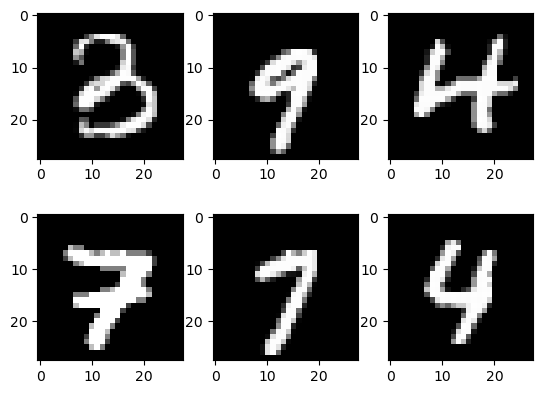

In [50]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
# plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image("mnist_images", img_grid)
writer.close()

In [51]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and softmax at the end as both are applied
        # in the loss function
        return out

In [52]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [53]:
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [54]:
writer.add_graph(model, samples.reshape(-1, 28*28))
writer.close()

In [55]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 28x28 => 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        l = loss(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        running_loss += l.item()
        
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {l.item()}')
            
            writer.add_scalar("training loss", running_loss/100, epoch * n_total_steps + i)
            writer.add_scalar("accuracy", running_correct/100, epoch * n_total_steps + i)
            
            running_loss = 0.0
            running_correct = 0

epoch 1/2, step 100/600, loss = 0.331348180770874
epoch 1/2, step 200/600, loss = 0.3973886966705322
epoch 1/2, step 300/600, loss = 0.25196343660354614
epoch 1/2, step 400/600, loss = 0.1815909594297409
epoch 1/2, step 500/600, loss = 0.2265484780073166
epoch 1/2, step 600/600, loss = 0.24174334108829498
epoch 2/2, step 100/600, loss = 0.21218879520893097
epoch 2/2, step 200/600, loss = 0.19727244973182678
epoch 2/2, step 300/600, loss = 0.14468999207019806
epoch 2/2, step 400/600, loss = 0.1434534192085266
epoch 2/2, step 500/600, loss = 0.22789177298545837
epoch 2/2, step 600/600, loss = 0.1509454995393753


In [56]:
label = []
preds = []

In [57]:
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # values, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        
        label.append(predictions)
        preds.append(class_predictions)
        
    label = torch.cat(label) # concatenate all the labels to 1D
    preds = torch.cat([torch.stack(batch) for batch in preds])
        
    acc = 100.0 * n_correct / n_samples
    print(f"accuracy = {acc}")
    
    classes = range(10)
    for i in classes:
        labels_i = label == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0) 
        writer.close()

accuracy = 95.37
